In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"] = "1"

In [4]:
import ipyparallel as ipp

In [5]:
cluster = ipp.Cluster(engines='mpi', n=10)

In [6]:
rc = cluster.start_and_connect_sync()

Starting 10 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

In [7]:
dv = rc[:]

In [8]:
dv.block = True

In [9]:
%pxconfig --block

In [58]:
%%px --local
import os
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers
import matplotlib as mpl

from aps_ai.beamline34IDC.optimization.display_utils import LivePlotCallback
from aps_ai.beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob
import IPython

In [11]:
%%px
%load_ext autoreload
%autoreload 2

In [12]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [13]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
dv['DEFAULT_RANDOM_SEED'] = DEFAULT_RANDOM_SEED

In [14]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'

temp_work_dir_root = f'{base_dir}/tmp_work_dir_{DEFAULT_RANDOM_SEED}'
if not os.path.isdir(temp_work_dir_root):
    os.mkdir(temp_work_dir_root)
dv['orig_work_dir'] = orig_work_dir
dv['temp_work_dir_root'] = temp_work_dir_root

In [15]:
%%px 
os.chdir(temp_work_dir_root)
temp_work_dir = f'{temp_work_dir_root}/rank_{rank}'
os.mkdir(temp_work_dir)
os.chdir(temp_work_dir)

In [16]:
%%px
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [17]:
%%px --local
move_motors = ['hkb_1_2']
input_beam_path = "primary_optics_system_beam.dat"

motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
#fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'

In [18]:
%%px
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)

%px:   0%|          | 0/1 [00:00<?, ?tasks/s]

[stdout:0] 7.462743573560718e-05


[output:0]

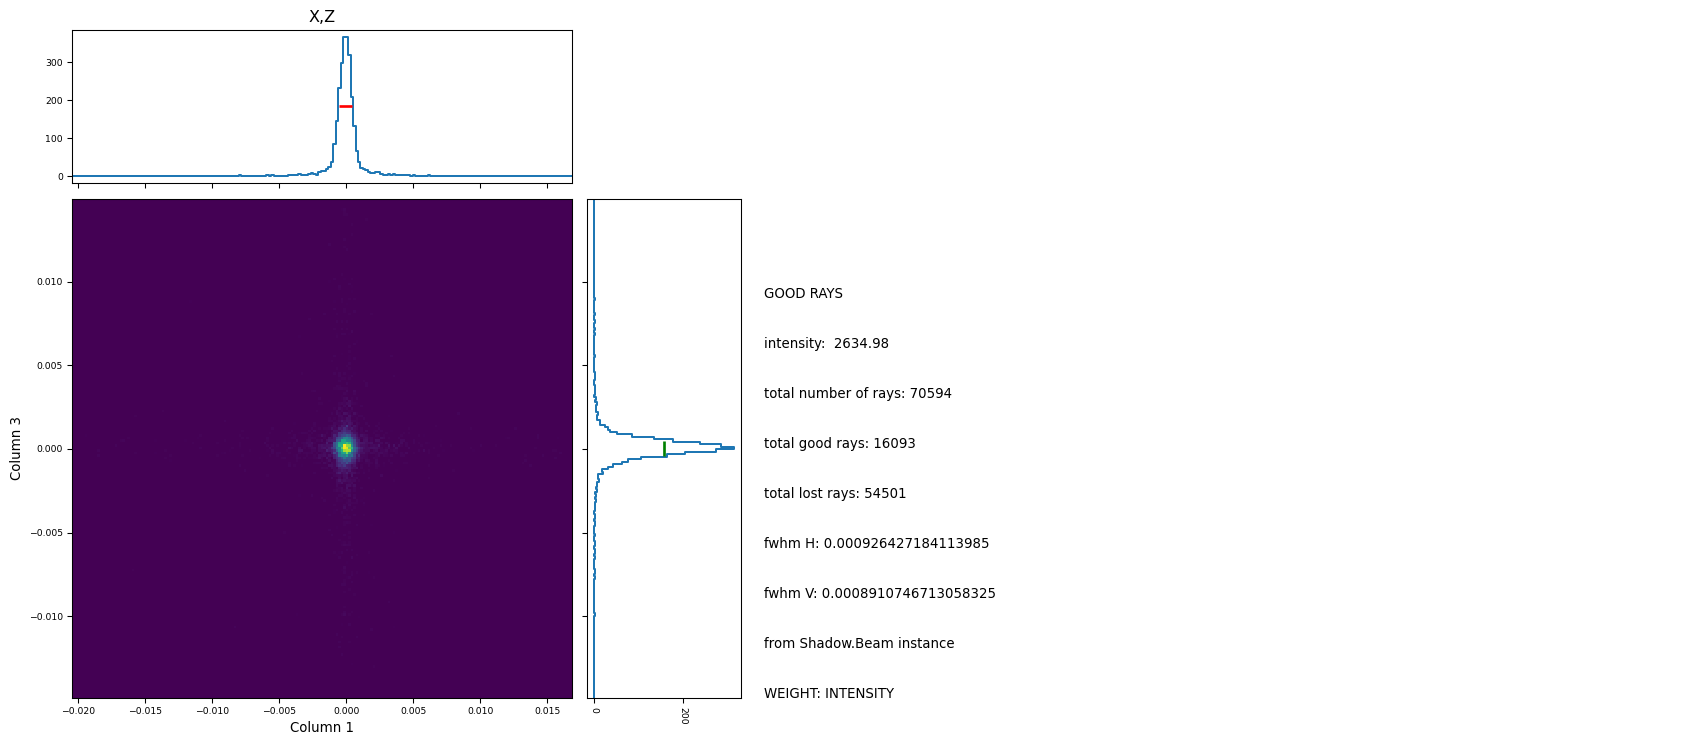

In [19]:
 %%px --targets 0 
# this is equivalent to using if rank == 0
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system=focusing_system, 
                                                                random_seed=DEFAULT_RANDOM_SEED)
print(centroid)

_ = plot_shadow_beam_spatial_distribution(out_beam)

In [20]:
%%px 
if rank == 0:
    initial_hkb_1_2 = movers.get_absolute_positions(focusing_system, ['hkb_1_2'])
    initial_q = movers.get_absolute_positions(focusing_system, ['hkb_q'])
    print(initial_hkb_1_2, initial_q)
else:
    initial_hkb_1_2 = None

initial_hkb_1_2 = MPI.COMM_WORLD.bcast(initial_hkb_1_2, root=0)

[stdout:0] [(250.0515, 157.0341)] [120.0]


In [21]:
test_range = np.linspace(-5, 10, 31)
dv.scatter('test_range', test_range)    

In [22]:
%%px
qvals = []
for t in test_range:
    focusing_system = movers.move_motors(focusing_system, 'hkb_1_2', t, movement='relative')
    q_new = movers.get_absolute_positions(focusing_system, 'hkb_q')
    qvals.append(q_new)
    focusing_system = movers.move_motors(focusing_system, 'hkb_1_2', -t, movement='relative')
    
    #focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)

In [23]:
qvals = np.array(dv.gather('qvals'))

Text(0.5, 0, 'relative HKB bender move (in micron)')

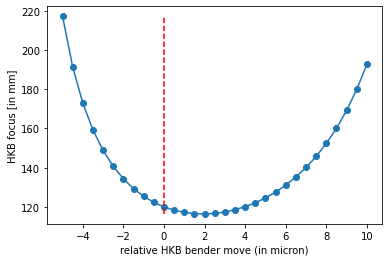

In [24]:
plt.plot(test_range, qvals, marker='o')
plt.vlines([0], ymin=qvals.min(), ymax=qvals.max(), color='r', ls='--')
plt.ylabel('HKB focus [in mm]')
plt.xlabel('relative HKB bender move (in micron)')


In [25]:
test_range = np.linspace(-10, 15, 31)
dv.scatter('test_range', test_range)  

In [26]:
%%px
qvals = []
for t in test_range:
    focusing_system = movers.move_motors(focusing_system, 'hkb_1_2', t, movement='relative')
    q_new = movers.get_absolute_positions(focusing_system, 'hkb_q')
    qvals.append(q_new)
    focusing_system = movers.move_motors(focusing_system, 'hkb_1_2', -t, movement='relative')
    
    #focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)

In [27]:
qvals = np.array(dv.gather('qvals'))

Text(0.5, 0, 'relative HKB bender move (in micron)')

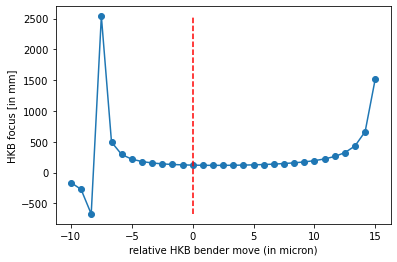

In [28]:
plt.plot(test_range, qvals, marker='o')
plt.vlines([0], ymin=qvals.min(), ymax=qvals.max(), color='r', ls='--')
plt.ylabel('HKB focus [in mm]')
plt.xlabel('relative HKB bender move (in micron)')


In [29]:
test_range = np.linspace(-10, 10, 31)
dv.scatter('test_range', test_range)    

In [30]:
%%px
qvals = []
for t in test_range:
    focusing_system = movers.move_motors(focusing_system, 'vkb_1_2', t, movement='relative')
    q_new = movers.get_absolute_positions(focusing_system, 'vkb_q')
    qvals.append(q_new)
    focusing_system = movers.move_motors(focusing_system, 'vkb_1_2', -t, movement='relative')
    
    #focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)

In [31]:
qvals = np.array(dv.gather('qvals'))

Text(0.5, 0, 'relative VKB bender move (in micron)')

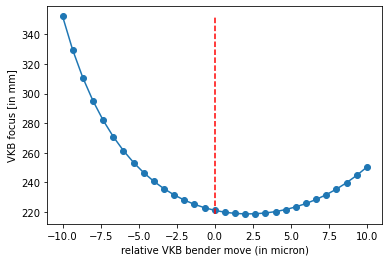

In [32]:
plt.plot(test_range, qvals, marker='o')
plt.vlines([0], ymin=qvals.min(), ymax=qvals.max(), color='r', ls='--')
plt.ylabel('VKB focus [in mm]')
plt.xlabel('relative VKB bender move (in micron)')


In [33]:
test_range = np.linspace(-15, 15, 31)
dv.scatter('test_range', test_range)  

In [34]:
%%px
qvals = []
for t in test_range:
    focusing_system = movers.move_motors(focusing_system, 'vkb_1_2', t, movement='relative')
    q_new = movers.get_absolute_positions(focusing_system, 'vkb_q')
    qvals.append(q_new)
    focusing_system = movers.move_motors(focusing_system, 'vkb_1_2', -t, movement='relative')
    
    #focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)

In [35]:
qvals = np.array(dv.gather('qvals'))

Text(0.5, 0, 'relative VKB bender move (in micron)')

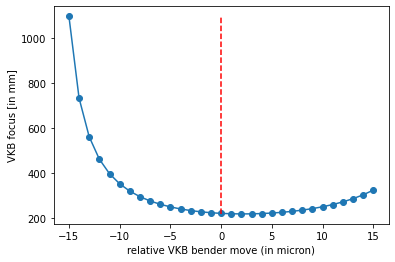

In [36]:
plt.plot(test_range, qvals, marker='o')
plt.vlines([0], ymin=qvals.min(), ymax=qvals.max(), color='r', ls='--')
plt.ylabel('VKB focus [in mm]')
plt.xlabel('relative VKB bender move (in micron)')


### Generating a high resolution joint color plot

In [47]:
hkb_range = np.linspace(-5, 5, 10)
dv['hkb_range'] = hkb_range

In [48]:
vkb_range = np.linspace(-5, 5, 10)
dv['vkb_range'] = vkb_range

In [60]:
%%px --block
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
centroids = np.zeros((hkb_range.size, vkb_range.size))
fwhms = np.zeros_like(centroids)
intensities = np.zeros_like(centroids)
hkb_qvals = np.zeros_like(centroids)
vkb_qvals = np.zeros_like(centroids)
hists = {}

In [61]:
jobs = np.arange(vkb_range.size * hkb_range.size)
dv.scatter('jobs', jobs, block=True)

In [62]:
%%px --block

for ih, hval in enumerate(hkb_range):
    exception_this = False
    for iv, vval in enumerate(vkb_range):
        
        
        run_here = (ih * vkb_range.size + iv) in jobs
        if not run_here: continue
        
        focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
        focusing_system = movers.move_motors(focusing_system, ['hkb_1_2', 'vkb_1_2'], 
                                             [hval, vval], movement='relative')
        h_q, v_q = movers.get_absolute_positions(focusing_system, motors=['hkb_q', 'vkb_q'])
        hkb_qvals[ih, iv] = h_q
        vkb_qvals[ih, iv] = v_q
        
        try:
            centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
        except Exception as e:
            exception_this = True
            
        if (out_beam is None) or exception_this:
            centroids[ih, iv] = np.nan
            fwhms[ih, iv] = np.nan
            intensities[ih, iv] = np.nan
            hists[(ih, iv)] = None
            continue
        fwhm, *_ = opt_common.get_fwhm(photon_beam=out_beam)
        intensity, *_ = opt_common.get_peak_intensity(photon_beam=out_beam)
        
        centroids[ih, iv] = centroid
        fwhms[ih, iv] = fwhm
        intensities[ih, iv] = intensity
        hists[(ih, iv)] = hist
        #
    #comm.barrier()
    #centroids = comm.gather(centroids, root=0)
    #fwhms = comm.gather(fwhms, root=0)
    #intensities = comm.gather(intensities, root=0)
    #hists = comm.gather(hists, root=0)
    #if rank == 0:
    #    centroids_all.append(centroids)
    #    fwhms_all.append(fwhms)
    #    intensities_all.append(intensities)
    #    hists_all.append(hists)
    #focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)

%px:   0%|          | 0/10 [00:00<?, ?tasks/s]

In [63]:
centroids_all = np.sum(dv['centroids'], axis=0)
fwhms_all = np.sum(dv['fwhms'], axis=0)
intensities_all = np.sum(dv['intensities'], axis=0)
hkb_qs_all = np.sum(dv['hkb_qvals'], axis=0)
vkb_qs_all = np.sum(dv['vkb_qvals'], axis=0)

In [64]:
temp_hists_all = dv.gather('hists', block=True)
hists_all = {}
for td in temp_hists_all:
    hists_all.update(td)

Text(0.5, 1.0, 'peak intensity')

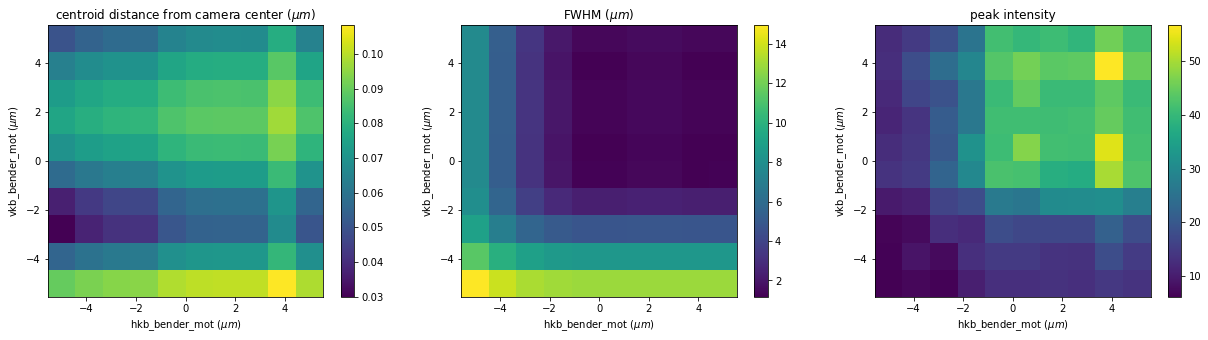

In [77]:
fig, axs = plt.subplots(1, 3, figsize=[21, 5])
plt.subplot(131)
plt.pcolormesh(hkb_range, vkb_range, centroids_all * 1000)
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title(r'centroid distance from camera center ($\mu m$)')

plt.subplot(132)
plt.pcolormesh(hkb_range, vkb_range, fwhms_all * 1000)
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title(r'FWHM ($\mu m$)')

plt.subplot(133)
plt.pcolormesh(hkb_range, vkb_range, intensities_all)
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title('peak intensity')

In [84]:
fwhms_all.min()

0.001164001834289559

Text(0.5, 1.0, 'peak intensity')

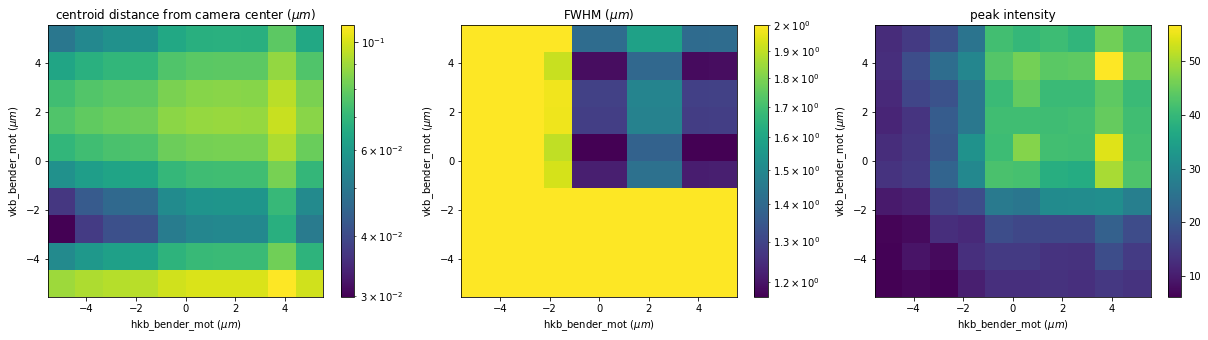

In [87]:
fig, axs = plt.subplots(1, 3, figsize=[21, 5])
plt.subplot(131)
plt.pcolormesh(hkb_range, vkb_range, centroids_all * 1000, norm=mpl.colors.LogNorm())
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title(r'centroid distance from camera center ($\mu m$)')

fwhm_microns = fwhms_all * 1000
fwhm_microns[fwhm_microns > 2.0] = 2.0
plt.subplot(132)
plt.pcolormesh(hkb_range, vkb_range, fwhm_microns, norm=mpl.colors.LogNorm())
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title(r'FWHM ($\mu m$)')

plt.subplot(133)
plt.pcolormesh(hkb_range, vkb_range, intensities_all)
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title('peak intensity')

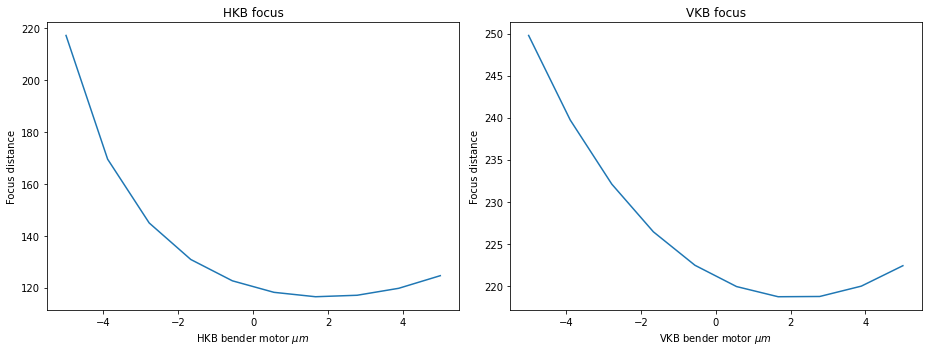

In [94]:
fig, axs = plt.subplots(1, 2, figsize=[13, 5])
plt.subplot(121)
plt.plot( hkb_range, hkb_qs_all[:,0])
plt.title('HKB focus')
plt.xlabel(r'HKB bender motor $\mu m$')
plt.ylabel('Focus distance')
plt.subplot(122)
plt.plot( vkb_range, vkb_qs_all[0])
plt.title('VKB focus')
plt.xlabel(r'VKB bender motor $\mu m$')
plt.ylabel('Focus distance')
plt.tight_layout()

### Generating a high resolution joint color plot closer to the minimum

In [105]:
hkb_range = np.linspace(-1, 1, 10)
dv['hkb_range'] = hkb_range

In [106]:
vkb_range = np.linspace(-1, 1, 10)
dv['vkb_range'] = vkb_range

In [107]:
%%px --block
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
centroids = np.zeros((hkb_range.size, vkb_range.size))
fwhms = np.zeros_like(centroids)
intensities = np.zeros_like(centroids)
hkb_qvals = np.zeros_like(centroids)
vkb_qvals = np.zeros_like(centroids)
hists = {}

In [108]:
jobs = np.arange(vkb_range.size * hkb_range.size)
dv.scatter('jobs', jobs, block=True)

In [109]:
%%px --block

for ih, hval in enumerate(hkb_range):
    exception_this = False
    for iv, vval in enumerate(vkb_range):
        
        
        run_here = (ih * vkb_range.size + iv) in jobs
        if not run_here: continue
        
        focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
        focusing_system = movers.move_motors(focusing_system, ['hkb_1_2', 'vkb_1_2'], 
                                             [hval, vval], movement='relative')
        h_q, v_q = movers.get_absolute_positions(focusing_system, motors=['hkb_q', 'vkb_q'])
        hkb_qvals[ih, iv] = h_q
        vkb_qvals[ih, iv] = v_q
        
        try:
            centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
        except Exception as e:
            exception_this = True
            
        if (out_beam is None) or exception_this:
            centroids[ih, iv] = np.nan
            fwhms[ih, iv] = np.nan
            intensities[ih, iv] = np.nan
            hists[(ih, iv)] = None
            continue
        fwhm, *_ = opt_common.get_fwhm(photon_beam=out_beam)
        intensity, *_ = opt_common.get_peak_intensity(photon_beam=out_beam)
        
        centroids[ih, iv] = centroid
        fwhms[ih, iv] = fwhm
        intensities[ih, iv] = intensity
        hists[(ih, iv)] = hist
        #
    #comm.barrier()
    #centroids = comm.gather(centroids, root=0)
    #fwhms = comm.gather(fwhms, root=0)
    #intensities = comm.gather(intensities, root=0)
    #hists = comm.gather(hists, root=0)
    #if rank == 0:
    #    centroids_all.append(centroids)
    #    fwhms_all.append(fwhms)
    #    intensities_all.append(intensities)
    #    hists_all.append(hists)
    #focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)

%px:   0%|          | 0/10 [00:00<?, ?tasks/s]

In [110]:
centroids_all = np.sum(dv['centroids'], axis=0)
fwhms_all = np.sum(dv['fwhms'], axis=0)
intensities_all = np.sum(dv['intensities'], axis=0)
hkb_qs_all = np.sum(dv['hkb_qvals'], axis=0)
vkb_qs_all = np.sum(dv['vkb_qvals'], axis=0)

In [111]:
temp_hists_all = dv.gather('hists', block=True)
hists_all = {}
for td in temp_hists_all:
    hists_all.update(td)

Text(0.5, 1.0, 'peak intensity')

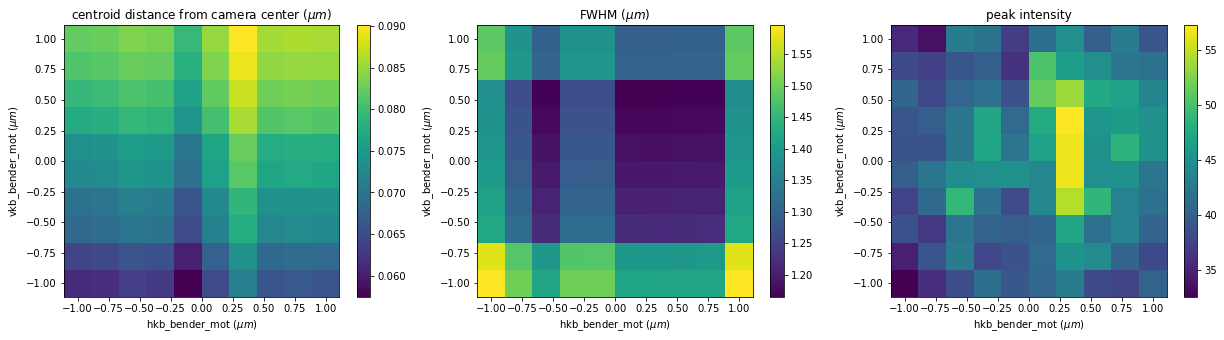

In [112]:
fig, axs = plt.subplots(1, 3, figsize=[21, 5])
plt.subplot(131)
plt.pcolormesh(hkb_range, vkb_range, centroids_all * 1000)
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title(r'centroid distance from camera center ($\mu m$)')

plt.subplot(132)
plt.pcolormesh(hkb_range, vkb_range, fwhms_all * 1000)
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title(r'FWHM ($\mu m$)')

plt.subplot(133)
plt.pcolormesh(hkb_range, vkb_range, intensities_all)
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title('peak intensity')

In [113]:
fwhms_all.min()

0.0011644710163276238

Text(0.5, 1.0, 'peak intensity')

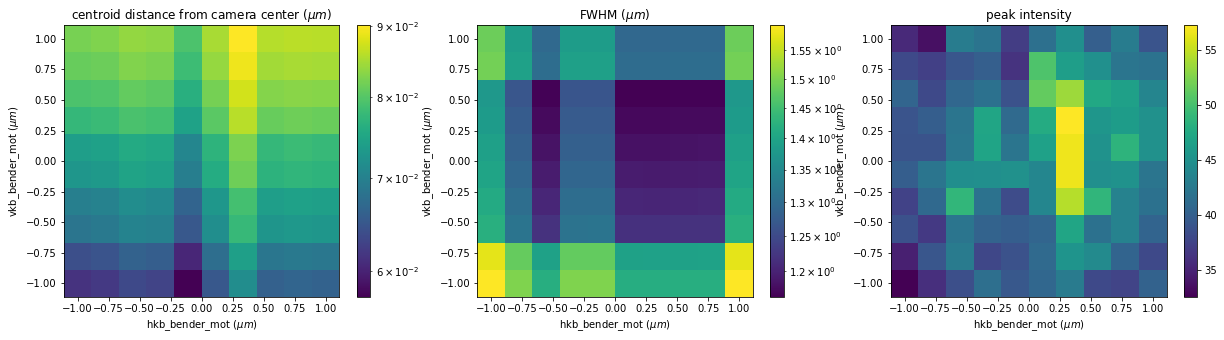

In [114]:
fig, axs = plt.subplots(1, 3, figsize=[21, 5])
plt.subplot(131)
plt.pcolormesh(hkb_range, vkb_range, centroids_all * 1000, norm=mpl.colors.LogNorm())
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title(r'centroid distance from camera center ($\mu m$)')

fwhm_microns = fwhms_all * 1000
fwhm_microns[fwhm_microns > 2.0] = 2.0
plt.subplot(132)
plt.pcolormesh(hkb_range, vkb_range, fwhm_microns, norm=mpl.colors.LogNorm())
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title(r'FWHM ($\mu m$)')

plt.subplot(133)
plt.pcolormesh(hkb_range, vkb_range, intensities_all)
plt.xlabel(r'hkb_bender_mot ($\mu m$)')
plt.ylabel('vkb_bender_mot ($\mu m$)')
plt.colorbar()
plt.title('peak intensity')

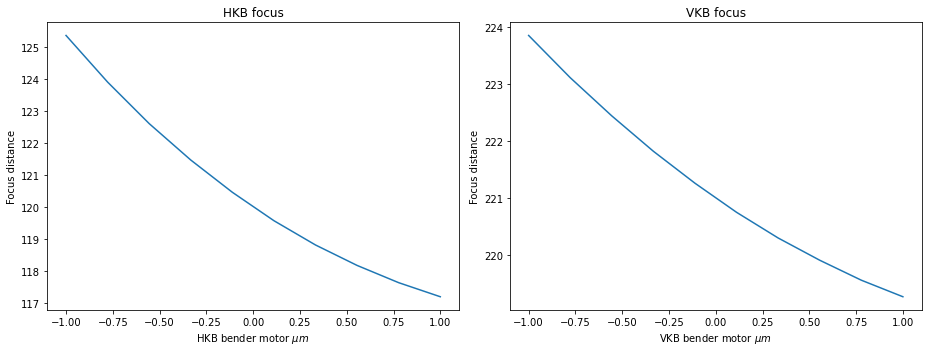

Stopping controller
Failed to remove /gpfs/fs1/home/skandel/.ipython/profile_default/log/ipcontroller-1649469485-gwiy-1060311.log: [Errno 2] No such file or directory: '/gpfs/fs1/home/skandel/.ipython/profile_default/log/ipcontroller-1649469485-gwiy-1060311.log'
Controller stopped: {'exit_code': 0, 'pid': 1278030, 'identifier': 'ipcontroller-1649469485-gwiy-1060311'}
Stopping engine(s): 1649469486


Stopping cluster <Cluster(cluster_id='1649469485-gwiy', profile='default', controller=<running>, engine_sets=['1649469486'])>


Failed to remove /gpfs/fs1/home/skandel/.ipython/profile_default/log/ipengine-1649469485-gwiy-1649469486-1060311.log: [Errno 2] No such file or directory: '/gpfs/fs1/home/skandel/.ipython/profile_default/log/ipengine-1649469485-gwiy-1649469486-1060311.log'
engine set stopped 1649469486: {'exit_code': 1, 'pid': 1278101, 'identifier': 'ipengine-1649469485-gwiy-1649469486-1060311'}


In [115]:
fig, axs = plt.subplots(1, 2, figsize=[13, 5])
plt.subplot(121)
plt.plot( hkb_range, hkb_qs_all[:,0])
plt.title('HKB focus')
plt.xlabel(r'HKB bender motor $\mu m$')
plt.ylabel('Focus distance')
plt.subplot(122)
plt.plot( vkb_range, vkb_qs_all[0])
plt.title('VKB focus')
plt.xlabel(r'VKB bender motor $\mu m$')
plt.ylabel('Focus distance')
plt.tight_layout()